In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt

In [11]:
# 1 Selecting Features that can be calculated in real-time or near-real time (Based on the URL or Lookups)

url_only_features = [
    "URLLength", "DomainLength", "IsDomainIP",
    "URLSimilarityIndex", "CharContinuationRate", 
    "TLDLegitimateProb", "URLCharProb", "TLDLength",
    "NoOfSubDomain", "HasObfuscation", "NoOfObfuscatedChar",
    "ObfuscationRatio", "NoOfLettersInURL", "LetterRatioInURL",
    "NoOfDegitsInURL", "DegitRatioInURL", "NoOfEqualsInURL",
    "NoOfQMarkInURL", "NoOfAmpersandInURL",
    "NoOfOtherSpecialCharsInURL", "SpacialCharRatioInURL",
    "IsHTTPS", "Bank", "Pay", "Crypto"
]

In [12]:
# 2 Load dataset
df = pd.read_csv("Dataset/Dataset.csv").drop("FILENAME", axis=1)

X = df[url_only_features].values
y = df["label"].values

In [13]:
# 3 Shuffle dataset for streaming simulation

np.random.seed(42)
idx = np.random.permutation(len(X))
X, y = X[idx], y[idx]


In [14]:
# 4 Create seed set: K samples per class

K = 25

initial_idx = []
class_counts = {c: 0 for c in np.unique(y)}

for i in range(len(X)):
    label = y[i]
    if class_counts[label] < K:
        initial_idx.append(i)
        class_counts[label] += 1
    
    # Stop if we already gathered K for each class
    if all(count >= K for count in class_counts.values()):
        break

X0 = X[initial_idx]
y0 = y[initial_idx]

print("Seed set size:", len(X0))
print("Seed set class distribution:", class_counts)

Seed set size: 50
Seed set class distribution: {np.int64(0): 25, np.int64(1): 25}


In [15]:
# 5 Initialize incremental models

models = {
    "SGD": SGDClassifier(loss="log_loss", learning_rate="optimal", random_state=42),
    "PassiveAggressive": PassiveAggressiveClassifier(random_state=42),
    "BernoulliNB": BernoulliNB()
}

# Each model needs to see all classes at least once
for name, model in models.items():
    model.partial_fit(X0, y0, classes=np.unique(y))

In [16]:
# 6 Stream samples one-by-one

acc_logs = {name: [] for name in models}
first_100_records = []

for i in range(len(X)):
    xi = X[i].reshape(1, -1)
    yi = y[i]

    record = {"Index": i, "Actual": yi}

    for name, model in models.items():
        pred = model.predict(xi)[0]
        acc_logs[name].append(int(pred == yi))
        record[f"{name}_Pred"] = pred

        # Update model with true label
        model.partial_fit(xi, [yi])

    # Save first 100 prediction records
    if i < 100:
        first_100_records.append(record)

print("\n=== First 100 Prequential Predictions ===")
df_first100 = pd.DataFrame(first_100_records)
print(df_first100)


=== First 100 Prequential Predictions ===
    Index  Actual  SGD_Pred  PassiveAggressive_Pred  BernoulliNB_Pred
0       0       1         0                       0                 1
1       1       0         0                       0                 0
2       2       0         0                       0                 0
3       3       0         1                       1                 0
4       4       1         1                       0                 1
..    ...     ...       ...                     ...               ...
95     95       1         1                       1                 1
96     96       1         1                       1                 1
97     97       0         0                       0                 0
98     98       0         0                       0                 0
99     99       0         0                       0                 0

[100 rows x 5 columns]


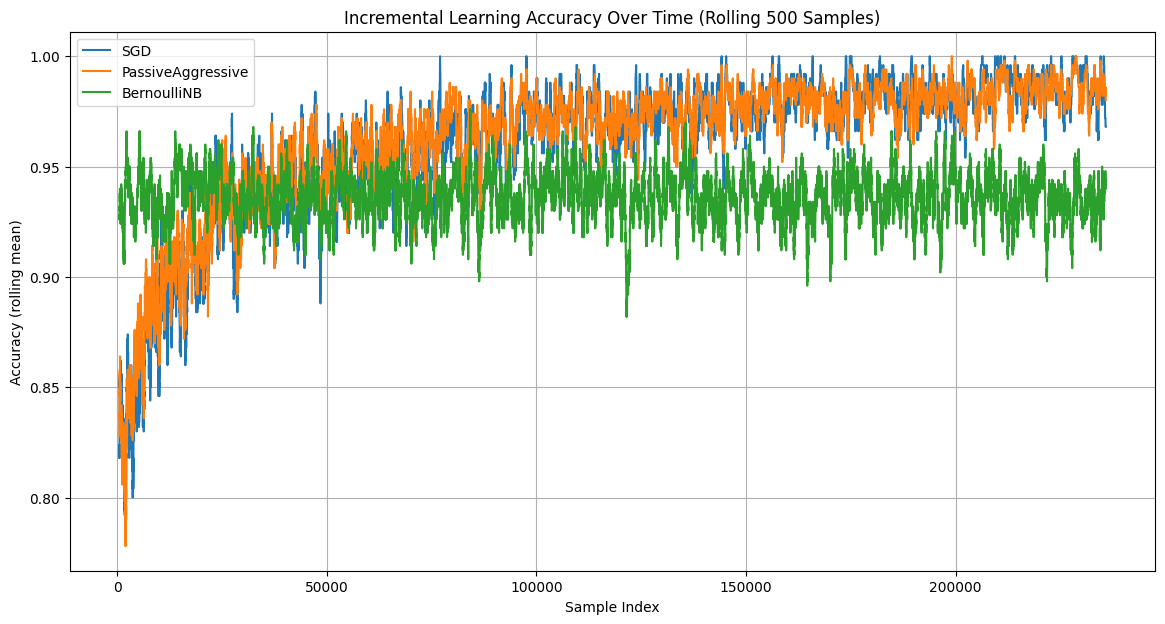

In [17]:
# 7 Plot accuracy curves

plt.figure(figsize=(14, 7))
for name in models:
    plt.plot(pd.Series(acc_logs[name]).rolling(500).mean(), label=name)

plt.title("Incremental Learning Accuracy Over Time (Rolling 500 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Accuracy (rolling mean)")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# 8 Final comparison table

final_scores = {name: np.mean(acc_logs[name]) for name in models}
results_df = pd.DataFrame.from_dict(final_scores, orient="index", columns=["Incremental_Accuracy"])
print(results_df)

                   Incremental_Accuracy
SGD                            0.960309
PassiveAggressive              0.961865
BernoulliNB                    0.936093
